#### PA 2 - ID3 Decision Tree Classifier

Name: Viswesh Uppalapati 

PID: A15600068

#### Problem 1.1 Tree Structure

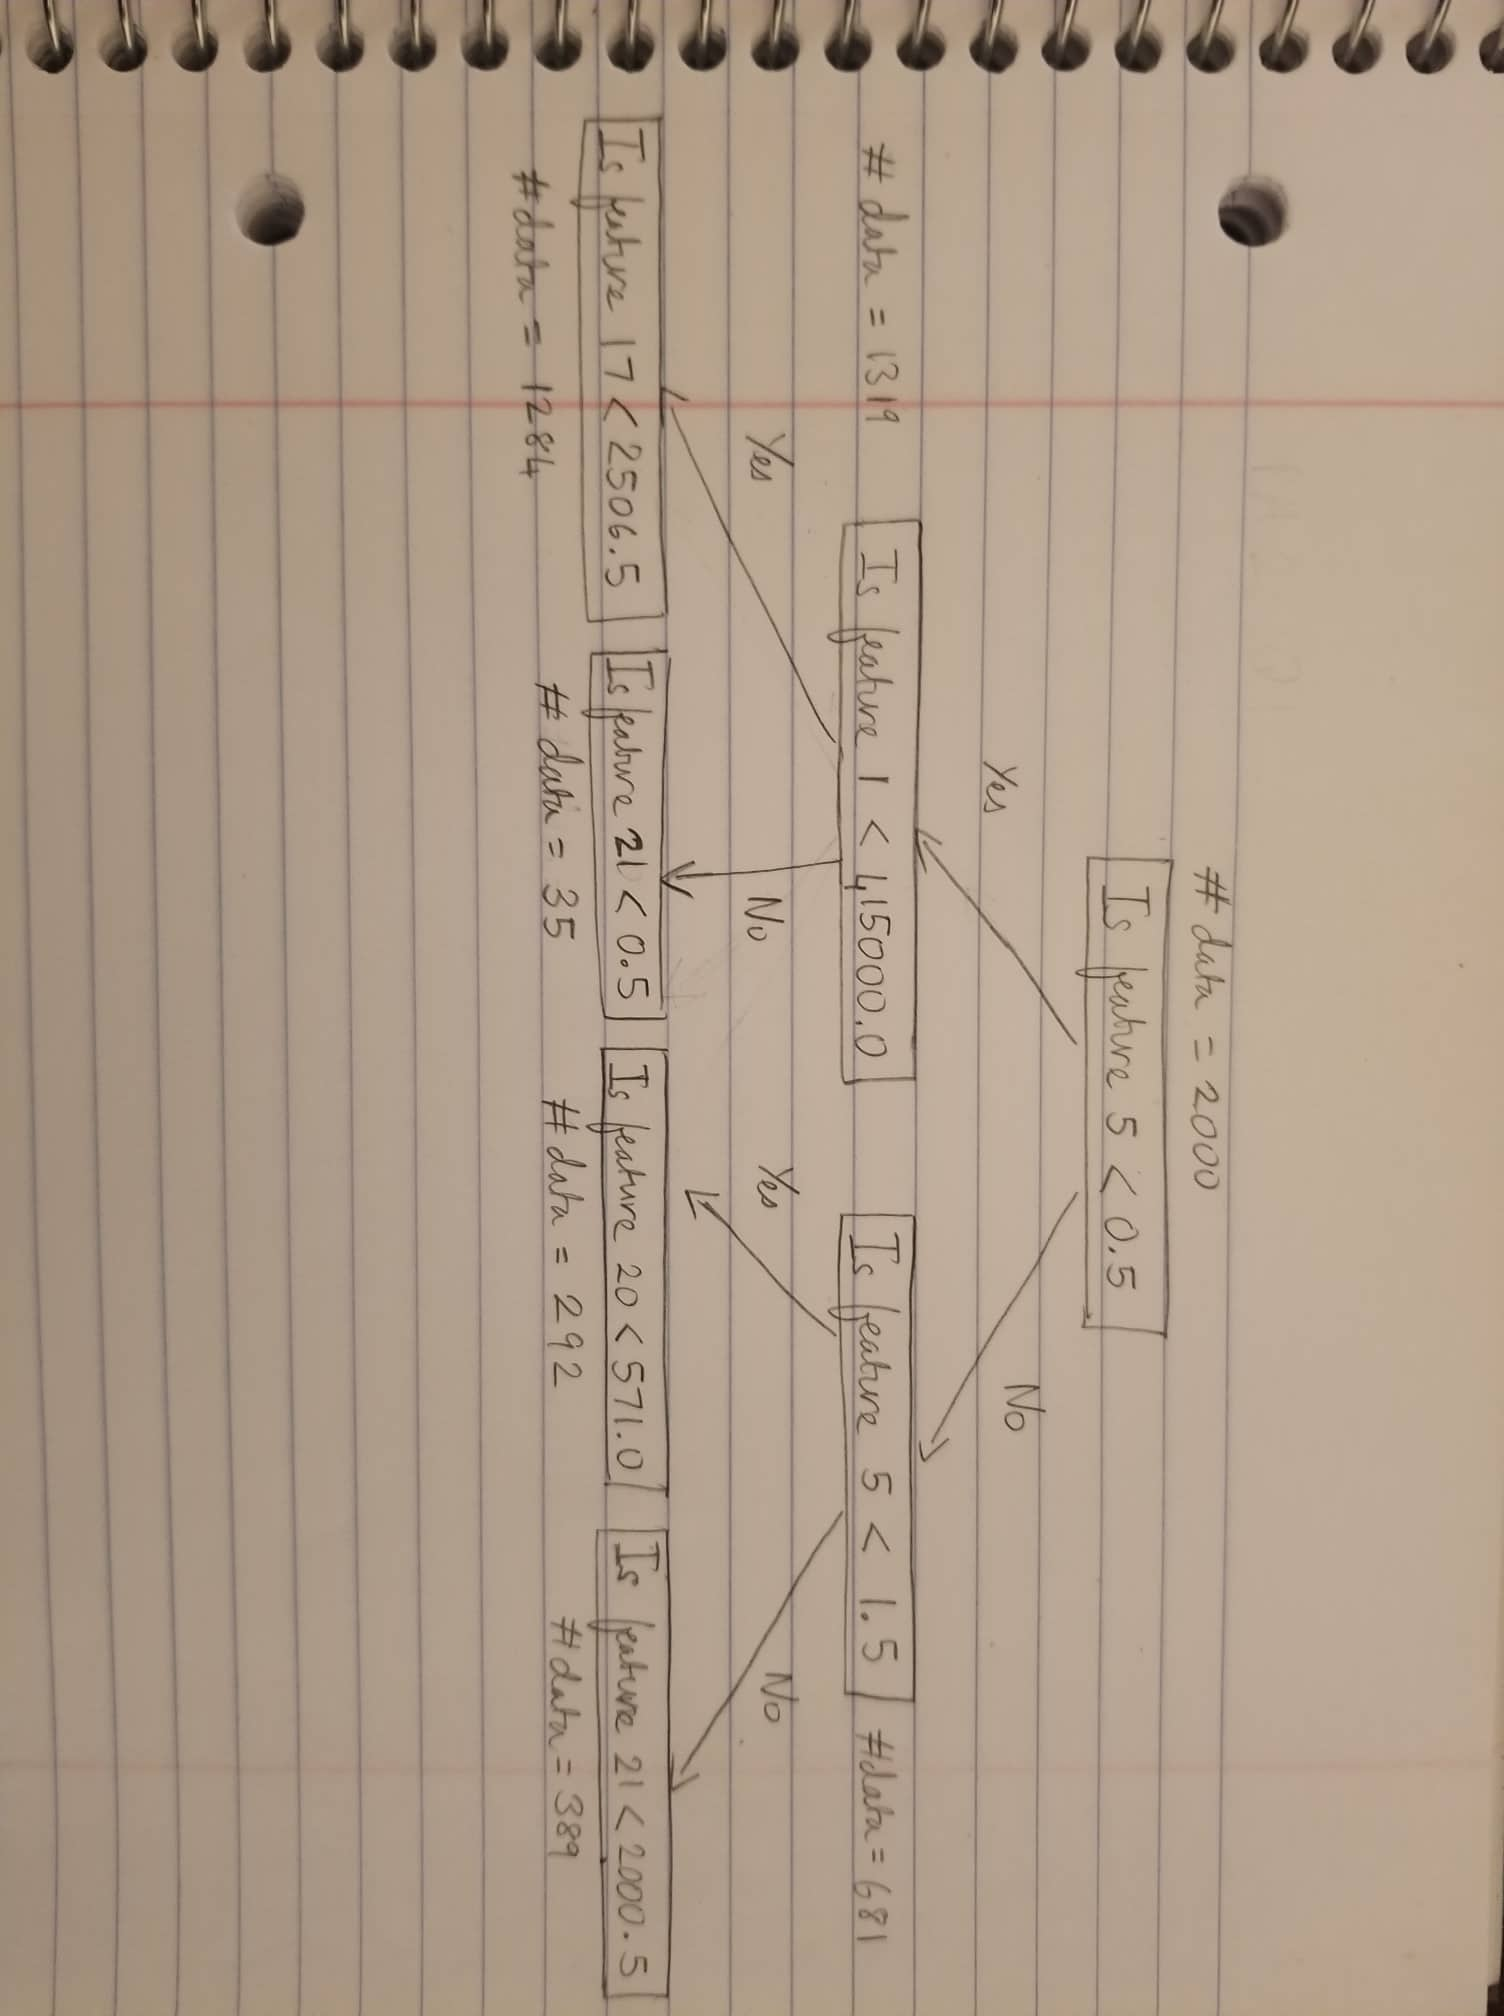

#### Problem 1.2 Errors Before Pruning

**Training Error:** 0.0

**Test Error:** 0.175

#### Problem 1.3 Errors After Pruning

Errors after first prune:

**Validation Error:** 0.122

**Test Error:** 0.117

Errors after second prune:

**Training Error:** 0.107

**Test Error:** 0.103

#### Problem 1.4 Most Prominent Feature

Since the final tree after pruning only contains 3 nodes with only 1 of the nodes being a rule, the most prominent feature is feature 5 (index 4) with a threshold of 0.5. According to the features table, the feature at index 4 is PAYMENT_DELAY_SEPTEMBER, which is the most prominent feature that predicts credit card default.

#### Import and Data

In [298]:
# needed imports

import pandas as pd
import numpy as np
import os

from scipy.stats import entropy
from collections import deque 

In [299]:
# What each column in the data corresponds to

features = pd.read_csv('pa2features.txt', sep = " ", header = None)
features

,0
0,LIMIT_BAL
1,SEX
2,COLLEGE_ABOVE
3,AGE
4,PAYMENT_DELAY_SEPTEMBER
5,PAYMENT_DELAY_AUGUST
6,PAYMENT_DELAY_JULY
7,PAYMENT_DELAY_JUNE
8,PAYMENT_DELAY_MAY
9,PAYMENT_DELAY_APRIL


In [300]:
# Data Reading

train_data = pd.read_csv('pa2train.txt', sep=" ", header = None).drop(23, axis = 1).to_numpy()
val_data = pd.read_csv('pa2validation.txt', sep=" ", header = None).drop(23, axis = 1).to_numpy()
test_data = pd.read_csv('pa2test.txt', sep = " ", header = None).drop(23, axis = 1).to_numpy()

#### ID3 Decision Tree Algorithm Before Pruning

In [301]:
# Node class that the DTree will be built from

class Node():
    
    def __init__(self, rule, data, is_pure, left, right):
        self.rule = rule # feature and threshold used for the split
        self.data = data # data at the current node
        self.left = left # left node data < threshold
        self.right = right # right node data >= threshold
        self.is_pure = is_pure # whether the node is pure
        self.label = None # label of pure node
        self.parent = None # to keep track of the parent node when pruning

In [302]:
# Entropy calculator

def calc_entropy(data):
    # get probability distributions of the label column
    label_idx = 22
    probabilities = np.unique(data[:, label_idx], return_counts = True)[1] / data[:, label_idx].size
    
    # return entropy from scipy.stats
    return entropy(probabilities)#-1 * np.sum(temp)

In [303]:

def calc_info_gain(data, feature_idx, threshold):
    
    # split the data based on threshold
    left_split = data[data[:, feature_idx] < threshold, :]
    right_split = data[data[:, feature_idx] >= threshold, :]

    
    # calculate total entropy of data H(X)
    entropy = calc_entropy(data)
    
    # calculate entropy of each split
    split_entropies = [calc_entropy(left_split), calc_entropy(right_split)]
    
    # calculate probability dist of the threshold split
    prob_dist = [(left_split[:, feature_idx].size / data[:, feature_idx].size), 
                 (right_split[:, feature_idx].size / data[:, feature_idx].size)]

    # calculate the total conditional entropy H(X | Z)
    cnd_entropy = np.sum(np.array(prob_dist) * np.array(split_entropies))
    
    # return info gain H(X) - H(X|Z)
    return entropy - cnd_entropy

In [304]:
# ID3 Tree Building Algorithm

def build_tree(node):
    
    label_idx = 22
    data = node.data
    
    # stop building branch if node is pure
    labels_present = np.unique(data[:, label_idx])
    if labels_present.size == 1:
        node.is_pure = True
        node.label = labels_present[0]
        return node

    # Calculate the info gain for all of features and thresholds
    info_gains = []
    threshold_used = []
    feature_used = []
    
    for feature_idx in range(data[0].size):
        if feature_idx == label_idx:
            break
        
        temp = np.unique(train_data[:, feature_idx])
        possible_thresholds = (temp[1:] + temp[:-1]) / 2
        
        for threshold in possible_thresholds:
            info_gain = calc_info_gain(data, feature_idx, threshold)
            info_gains.append(info_gain)
            threshold_used.append(threshold)
            feature_used.append(feature_idx)
    
    # get the max info gain and select rule
    max_ig_idx = np.argmax(info_gains)
    node.rule = (feature_used[max_ig_idx], threshold_used[max_ig_idx])
    
    # split data
    left = data[data[:, node.rule[0]] < node.rule[1], :]
    right = data[data[:, node.rule[0]] >= node.rule[1], :]
    
    # recurse to the left and right
    node.left = build_tree(Node(None, left, False, None, None))
    node.right = build_tree(Node(None, right, False, None, None))
    
    # set parent nodes for pruning
    node.left.parent = node
    node.right.parent = node
    
    # return for the non-leaf nodes
    return node

#### Tree Building and Error Testing

In [305]:
# Build the tree from the root

root = Node(None, train_data, False, None, None)
tree_root = build_tree(root)
tree_root

In [306]:
# Printing to see levels for Q1 tree drawing and getting to know tree structure

print("Level 0: " + str(tree_root.rule))
print("Level 1 left: " + str(tree_root.left.rule))
print("Level 1 right: " + str(tree_root.right.rule))
print("Level 2 left: " + str(tree_root.left.left.rule))
print("Level 2 center right: " + str(tree_root.left.right.rule))
print("Level 2 center left: " + str(tree_root.right.left.rule))
print("Level 2 right: " + str(tree_root.right.right.rule))

Level 0: (4, 0.5)
Level 1 left: (0, 415000.0)
Level 1 right: (4, 1.5)
Level 2 left: (16, 2506.5)
Level 2 center right: (20, 0.5)
Level 2 center left: (19, 571.0)
Level 2 right: (20, 2000.5)


In [307]:
# Checking how much of the training data is present in each node 

print("Level 0: " + str(tree_root.data[:, 0].shape))
print("Level 1 left: " + str(tree_root.left.data[:, 0].shape))
print("Level 1 right: " + str(tree_root.right.data[:, 0].shape))
print("Level 2 left: " + str(tree_root.left.left.data[:, 0].shape))
print("Level 2 center right: " + str(tree_root.left.right.data[:, 0].shape))
print("Level 2 center left: " + str(tree_root.right.left.data[:, 0].shape))
print("Level 2 right: " + str(tree_root.right.right.data[:, 0].shape))

Level 0: (2000,)
Level 1 left: (1319,)
Level 1 right: (681,)
Level 2 left: (1284,)
Level 2 center right: (35,)
Level 2 center left: (292,)
Level 2 right: (389,)


In [308]:
# method that predicts the labels

def predict(col, root):
    
    # if it is a pure node, return its label
    if root.is_pure:
        return root.label
    
    feature = root.rule[0]
    threshold = root.rule[1]
    
    # if feature is less than threshold, traverse left, otherwise right
    if col[feature] < threshold:
        return predict(col, root.left)
    else:
        return predict(col, root.right)

In [309]:
# Function that calculates the error of ID3 tree on given data

def calc_error(data, tree):
    preds = []
    for x in range(data[:, 0].size):
        preds.append(predict(data[x, :], tree))
    
    train_error = np.count_nonzero(np.array(preds) != 
                data[:, 22]) / data[:, 0].size
    
    return train_error

In [310]:
# Calculation of Error of ID3 DTree on train_data

print("Train Error: " + str(calc_error(train_data, tree_root)))

Train Error: 0.0


In [311]:
# Calculation of Error of ID3 DTree on test_data

print("Test Error: " + str(calc_error(test_data, tree_root)))

Test Error: 0.175


#### Pruning ID3 Tree Using Validation Data

In [312]:
# Pruning algorithm for ID3 decision tree

# Function to get the most common label at a node
def most_common_label(data):
    label_idx = 22
    labels, counts = np.unique(data[:, label_idx], return_counts = True)
    return labels[np.argmax(counts)]

def prune(root, val_data):
    
    # queue to traverse in BFS order
    queue = deque()
    
    # append (node, is_left, is_right) for each node in tree into queue
    queue.append((root, False, False))

    while len(queue) > 0:
        
        # get all the info from each entry in queue
        temp = queue.popleft()
        node = temp[0]
        is_left = temp[1]
        is_right = temp[2]
        
        # case of root node
        if not (is_left or is_right):
            new_tree = Node(None, node.data, True, None, None)
            new_tree.label = most_common_label(new_tree.data)
            old_error = calc_error(val_data, node) 
            new_error = calc_error(val_data, new_tree)
            
            if new_error < old_error:
                return new_tree
        # case of non-root node
        else:
            # initialize new node
            new_node = Node(None, node.data, True, None, None)
            new_node.label = most_common_label(new_node.data)
            
            # get validation error of the old tree
            old_error = calc_error(val_data, root)
            
            # reset pointers for new_node
            new_node.parent = node.parent
            
            if is_left:
                node.parent.left = new_node
            elif is_right:
                node.parent.right = new_node
            
            # get validation error of the new tree
            new_error = calc_error(val_data, root)
            
            # return new tree if lower val error
            # otherwise reset pointers back to old node
            if new_error < old_error:
                return root
            else:
                if is_left:
                    node.parent.left = node
                elif is_right:
                    node.parent.right = node
            
        # append to queue in BFS order based on existence of node
        if node.left is not None:
            queue.append((node.left, True, False))
            
        if node.right is not None:
            queue.append((node.right, False, True))
        
        if node.left is None and node.right is None:
            continue
    
    # return original tree if no nodes need to be pruned
    return root

In [313]:
# Tree after pruning once
import copy

temp = copy.deepcopy(tree_root)
first_prune = prune(temp, val_data)
first_prune

In [314]:
# Validation and Test error after first prune

print("Validation Error: " + str(calc_error(val_data, first_prune)))
print("Test Error: " + str(calc_error(test_data, first_prune)))

Validation Error: 0.122
Test Error: 0.117


In [315]:
# Tree after pruning twice

new_copy = copy.deepcopy(first_prune)
second_prune = prune(new_copy, val_data)
second_prune

In [316]:
# Validation and Test error after second prune

print("Validation Error: " + str(calc_error(val_data, second_prune)))
print("Test Error: " + str(calc_error(test_data, second_prune)))

Validation Error: 0.107
Test Error: 0.103


In [317]:
# Initialize final tree and most prominent rule

final_tree = copy.deepcopy(second_prune)
final_tree.rule

(4, 0.5)